In [42]:
from sqlalchemy import text
from database.connection import session_local
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
sql = text("""
SELECT 
  elem ->> 'date' AS date, 
  elem ->> 'hour' AS hour, 
  
  (elem -> 'priceComponents'->0 ->> 'priceExcludingVat')::numeric AS taxes_ex_vat,
  (elem -> 'priceComponents'->0 ->> 'priceIncludingVat')::numeric AS taxes_in_vat,

  (elem -> 'priceComponents'->1 ->> 'priceExcludingVat')::numeric AS power_ex_vat,
  (elem -> 'priceComponents'->1 ->> 'priceIncludingVat')::numeric AS power_in_vat,

  (elem -> 'priceComponents'->2 ->> 'priceExcludingVat')::numeric AS grid_ex_vat,
  (elem -> 'priceComponents'->2 ->> 'priceIncludingVat')::numeric AS grid_in_vat,

  pa_code AS zip_code, 
  ci_name AS city, 
  c_name AS country

FROM t_postal_area 
JOIN t_city     ON t_city.ci_id = t_postal_area.ci_id 
JOIN t_province ON t_province.p_id = t_city.p_id
JOIN t_country  ON t_country.c_id = t_province.c_id,

LATERAL jsonb_array_elements(pa_data -> 'energy' -> 'todayHours') AS elem

WHERE pa_code = '10249'
""")

In [44]:
with session_local() as session:
    result = session.execute(sql)
    df = pd.DataFrame(result.fetchall(), columns=result.keys())

df['hour'] = df['hour'].astype(int)
df = df.sort_values(by='hour')

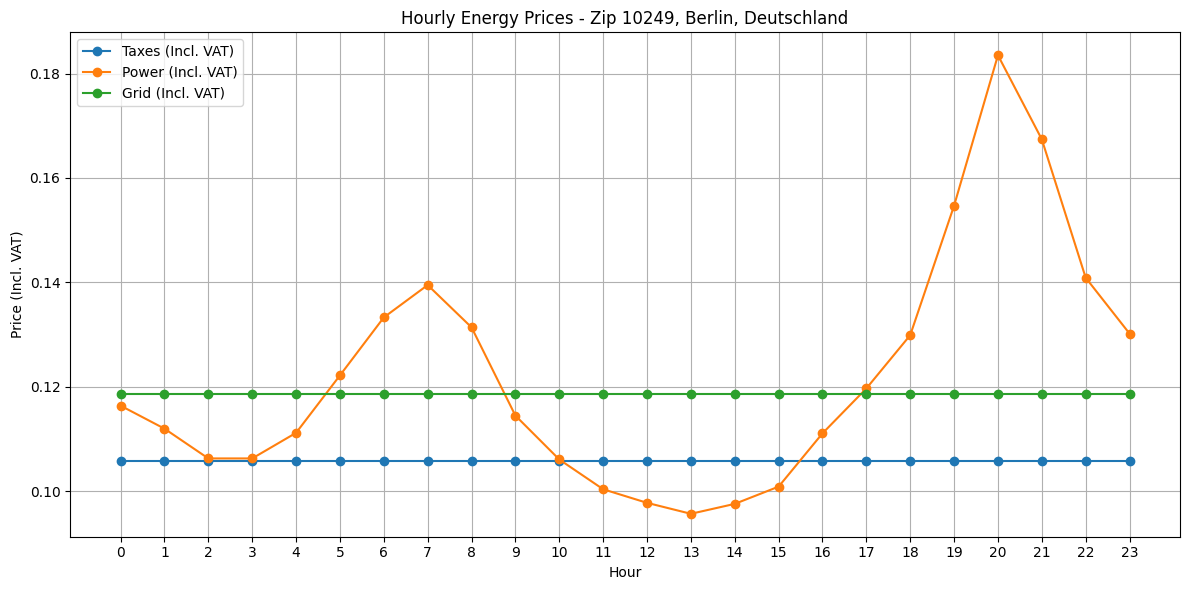

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(df['hour'], df['taxes_in_vat'], label='Taxes (Incl. VAT)', marker='o')
plt.plot(df['hour'], df['power_in_vat'], label='Power (Incl. VAT)', marker='o')
plt.plot(df['hour'], df['grid_in_vat'], label='Grid (Incl. VAT)', marker='o')

plt.title(f"Hourly Energy Prices - Zip {df['zip_code'].iloc[0]}, {df['city'].iloc[0]}, {df['country'].iloc[0]}")
plt.xlabel('Hour')
plt.ylabel('Price (Incl. VAT)')
plt.grid(True)
plt.legend()
plt.xticks(df['hour'])
plt.tight_layout()
plt.show()